In [1]:
#Loading required libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,BaggingRegressor,AdaBoostClassifier,AdaBoostRegressor,BaggingRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import keras
import seaborn as sns


Using TensorFlow backend.


In [2]:
data = pd.read_csv('project3_data.csv')
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [3]:
data_X = data[['X1','X2','X3','X4','X5','X6','X7','X8']]
data_Y = data[['Y1','Y2']]

In [4]:
Overall_Load = data_Y['Y1'] + data_Y['Y2']
Overall_Load= pd.DataFrame(data = Overall_Load,columns=['total_load'])
Overall_Load['efficiency_class'] = 'Medium_Eff'
Overall_Load.loc[Overall_Load.total_load < 28.75, ['efficiency_class']] = 'Low_Eff'
Overall_Load.loc[Overall_Load.total_load > 64.33 , ['efficiency_class']] = 'High_Eff'
Overall_Load.groupby('efficiency_class')['efficiency_class'].count()

efficiency_class
High_Eff      192
Low_Eff       192
Medium_Eff    384
Name: efficiency_class, dtype: int64

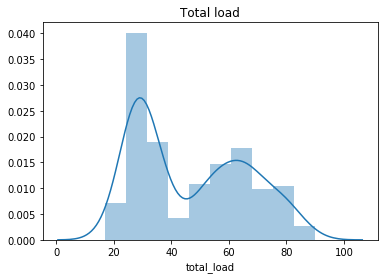

In [5]:
sns.distplot(Overall_Load['total_load'])
plt.title('Total load');

In [6]:
Overall_Load['efficiency_class'] = pd.Categorical(Overall_Load["efficiency_class"],ordered=True)


In [7]:
data_X.columns = ['relative_compactness','surface_area','wall_area','roof_area','overall_height','orientation','glazing_area','glazing_area_distribution']
data_Y.columns = ['heating_load','cooling_load']
data_Y.head()

,heating_load,cooling_load
0,15.55,21.33
1,15.55,21.33
2,15.55,21.33
3,15.55,21.33
4,20.84,28.28


In [8]:
data_Y_cool = data_Y['cooling_load']
data_Y_hot = data_Y['heating_load']

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_heat, X_test_heat, y_train_heat, y_test_heat = train_test_split(data_X, data_Y_hot, test_size = 0.2, random_state = 10)
X_train_heat = scaler.fit_transform(X_train_heat)
X_test_heat = scaler.transform(X_test_heat)
X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(data_X, data_Y_cool, test_size = 0.2, random_state = 10)
X_train_cool = scaler.fit_transform(X_train_cool)
X_test_cool = scaler.transform(X_test_cool)

In [9]:
#Defining R-square
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

In [10]:
from keras.wrappers.scikit_learn import KerasRegressor

def create_model_regressor_cooling():
    #create model
    model2 = Sequential()
    model2.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
    model2.add(Dense(4, kernel_initializer = 'normal', activation = 'relu')) # hidden layer
    model2.add(Dense(10, kernel_initializer = 'normal', activation = 'linear'))
    model2.add(Dense(1, kernel_initializer='normal'))
    #compile model
    model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    #return model
    return model2

In [11]:
from keras.wrappers.scikit_learn import KerasRegressor

def create_model_regressor_heating():
    #create model
    model = Sequential()
    model.add(Dense(8, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'relu')) # hidden layer
    model.add(Dense(10, kernel_initializer = 'normal', activation = 'linear'))
    model.add(Dense(1, kernel_initializer='normal'))
    #compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', coeff_determination])
    return model

In [12]:
param_grid = {'epochs':[50, 100, 200] , 'batch_size':[20, 50, 100]}

In [13]:
model1 = KerasRegressor(build_fn = create_model_regressor_cooling , verbose = 0)

grid_search = GridSearchCV(model1 , param_grid , cv =5)

grid_search.fit(X_train_cool, y_train_cool)
#
print('Best parameters for cooling load {}'.format(grid_search.best_params_))

train_r2_cool = r2_score(y_train_cool, grid_search.predict(X_train_cool))
print(train_r2_cool)
test_r2_cool = r2_score(y_test_cool, grid_search.predict(X_test_cool))
print(test_r2_cool)

Best parameters for cooling load {'batch_size': 50, 'epochs': 200}
0.869686726031
0.893870551334


In [14]:
model2 = KerasRegressor(build_fn = create_model_regressor_heating , verbose = 0)
grid_search = GridSearchCV(model2 , param_grid , cv =5)

grid_search.fit(X_train_heat, y_train_heat)
print('Best parameters for heating load {}'.format(grid_search.best_params_))

train_r2_heat = r2_score(y_train_heat, grid_search.predict(X_train_heat))
print(train_r2_heat)
test_r2_heat = r2_score(y_test_heat, grid_search.predict(X_test_heat))
print(test_r2_heat)

Best parameters for heating load {'batch_size': 50, 'epochs': 200}
0.906356179563
0.925660135935


In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, random_state = 0)


In [16]:
from sklearn.preprocessing import MinMaxScaler
MinMax = MinMaxScaler(feature_range= (0,1))
X_train_scaled = MinMax.fit_transform(X_train)
X_test_scaled = MinMax.transform(X_test)

In [17]:
linear = LinearRegression()
multi_linear = MultiOutputRegressor(linear,n_jobs=-1)
multi_linear.fit(X_train,y_train)
pred = multi_linear.predict(X_test)
print('The R2 score using Linear Regression on test data is:',r2_score(y_test,pred))


The R2 score using Linear Regression on test data is: 0.901099766134


In [18]:
param_grid = {'weights':['distance', 'uniform'], 'n_neighbors':range(4,100)}
grid_search_knn = MultiOutputRegressor(GridSearchCV(KNeighborsRegressor(), param_grid, cv=5,return_train_score=True),n_jobs=-1)
grid_search_knn.fit(X_train_scaled, y_train)
pred = grid_search_knn.predict(X_test_scaled)
print('The R2 score using KNN on test data is:',r2_score(y_test,pred))


The R2 score using KNN on test data is: 0.916534482585


In [19]:
param_grid = {"max_depth": [2, 4],
              "max_features": sp_randint(1, 4),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 10),
              "bootstrap": [True, False]}
random_search_rf = MultiOutputRegressor(RandomizedSearchCV(RandomForestRegressor(n_estimators=1000), param_distributions=param_grid,
                                   n_iter=40, random_state=0,n_jobs=-1, cv= 5,return_train_score=True),n_jobs=-1)
random_search_rf.fit(X_train, y_train)

pred = random_search_rf.predict(X_test)
print('The R2 score using Random Forests on test data is:',r2_score(y_test,pred))


The R2 score using Random Forests on test data is: 0.962927565721


In [20]:
new_param = {"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)}
svr = MultiOutputRegressor(GridSearchCV(SVR(kernel='linear'), new_param, cv=5,return_train_score=True))

svr.fit(X_train_scaled, y_train)
pred = svr.predict(X_test_scaled)
print('The R2 score using SVR and Linear Kernel on test data is:',r2_score(y_test,pred))

The R2 score using SVR and Linear Kernel on test data is: 0.892655735986


In [21]:
new_param = {"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)}
svr = MultiOutputRegressor(GridSearchCV(SVR(kernel='rbf'), new_param, cv=5,return_train_score=True))
svr.fit(X_train_scaled, y_train)
pred = svr.predict(X_test_scaled)
print('The R2 score using SVR and rbf Kernel on test data is:',r2_score(y_test,pred))

The R2 score using SVR and rbf Kernel on test data is: 0.985210650163


In [22]:
from sklearn.ensemble import BaggingRegressor
param_grid = {"max_samples": sp_randint(5,10),
              "max_features": sp_randint(1, 7),
             "bootstrap_features": [True,False],
             "bootstrap": [True,False]}

bagging_decision_tree = MultiOutputRegressor(RandomizedSearchCV(BaggingRegressor(DecisionTreeRegressor(),n_estimators=1000), param_distributions=param_grid,
                                   n_iter=30, random_state=0,n_jobs=-1,cv= 5,return_train_score=True),n_jobs=-1)

bagging_decision_tree.fit(X_train,y_train)
pred = bagging_decision_tree.predict(X_test)
print('The R2 score using Random forests on test data is:',r2_score(y_test,pred))



The R2 score using Random forests on test data is: 0.842151589979


In [23]:
param =  { "n_estimators": [100,500] }

base_dt=DecisionTreeRegressor()
ada_dt = AdaBoostRegressor(base_estimator=base_dt,learning_rate = 0.7,random_state=10)
adaboost_dt = MultiOutputRegressor(GridSearchCV(ada_dt,param_grid=param,n_jobs=-1),n_jobs=-1)
adaboost_dt.fit(X_train, y_train)
pred = adaboost_dt.predict(X_test)
print('The R2 score using adaboost on test data is:',r2_score(y_test,pred))


The R2 score using adaboost on test data is: 0.980006582087


In [24]:
param =  { "n_estimators": [100,500,1000] }

base_knn=KNeighborsRegressor()
ada_knn = AdaBoostRegressor(base_estimator=base_knn,learning_rate = 0.7,random_state=10)
adaboost_knn = MultiOutputRegressor(GridSearchCV(ada_knn,param_grid=param,n_jobs=-1),n_jobs=-1)
adaboost_knn.fit(X_train_scaled, y_train)
pred = adaboost_knn.predict(X_test_scaled)
print('The R2 score using base KNN in adaboost on test data is:',r2_score(y_test,pred))


The R2 score using base KNN in adaboost on test data is: 0.950079897703


In [25]:
param =  { "n_estimators": [100,500,1000] }
base_svr=SVR(kernel='linear')
ada_svr = AdaBoostRegressor(base_estimator=base_svr,learning_rate = 0.7,random_state=10)
adaboost_svr = MultiOutputRegressor(GridSearchCV(ada_svr,param_grid=param,n_jobs=-1),n_jobs=-1)
adaboost_svr.fit(X_train_scaled, y_train)
pred = adaboost_svr.predict(X_test_scaled)
print('The R2 score using base SVR in adaboost on test data is:',r2_score(y_test,pred))



The R2 score using base SVR in adaboost on test data is: 0.889777808566


In [26]:
param = {"min_samples_split": [3,4,5],
         "max_features": [2,3,4,5,6],
         'n_estimators': [100,500,1000]}

boost_svr = GradientBoostingRegressor(learning_rate =1.1,random_state=10)
mod_boost_svr = MultiOutputRegressor(GridSearchCV(boost_svr,param_grid=param,n_jobs=-1),n_jobs=-1)
mod_boost_svr.fit(X_train, y_train)
pred = mod_boost_svr.predict(X_test)
print('The R2 score using Gradient Boosting on test data is:',r2_score(y_test,pred))


The R2 score using Gradient Boosting on test data is: 0.992962473975


In [10]:
from keras.utils import np_utils

neural_data_Y = Overall_Load['efficiency_class']

In [11]:
from sklearn import preprocessing
encode = preprocessing.LabelEncoder()
encode.fit(neural_data_Y)
new_data_Y_category_1 = encode.transform(neural_data_Y)
new_data_Y_category_1 = keras.utils.to_categorical(new_data_Y_category_1,num_classes=3)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(data_X, new_data_Y_category_1, random_state = 0)

MinMax = MinMaxScaler(feature_range= (0,1))
X_train_cat_scaled = MinMax.fit_transform(X_train_cat)
X_test_cat_scaled = MinMax.transform(X_test_cat)
X_test_cat_scaled.shape

(192, 8)

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    #create model
    model = Sequential()
    model.add(Dense(8, input_dim=8, activation='relu'))
    model.add(Dense(13, activation='relu')) #hidden layer
    model.add(Dense(3,activation='softmax')) #output layer
    #compile model
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model
keras_classifier = KerasClassifier(build_fn = create_model , verbose =0 )
param = {'epochs':[50, 100, 200] , 'batch_size':[5,10,20, 50, 100]}
grid_search = GridSearchCV(estimator=keras_classifier , param_grid = param , cv =10,return_train_score=True )
grid_search.fit(X_train_cat_scaled,y_train_cat)

GridSearchCV(cv=10, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001D43A7E3978>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [50, 100, 200], 'batch_size': [5, 10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
print('The Mean test score is',grid_search.cv_results_['mean_test_score'])
print('The Mean train score is',grid_search.cv_results_['mean_train_score'])

The Mean test score is [ 0.92013889  0.95023148  0.96412037  0.9189815   0.92708335  0.94560186
  0.9050926   0.93402779  0.94212962  0.88946758  0.91319442  0.92939814
  0.86747683  0.90335647  0.92013887]
The Mean train score is [ 0.92759961  0.95433923  0.97093907  0.92462737  0.93865519  0.95331906
  0.91987586  0.93659993  0.95215479  0.89474188  0.92136186  0.93485987
  0.88470752  0.89975762  0.92798473]


## Conclusions

### When the aim is to do regression for predicting the heating and cooling load, Gradient boosting has an r2_score of 0.99 and it is the best predictor. Keras Classifier also gave very good accuarcy for classififcation problem.

## Effort Table
## Team Member 1: Devarsh Raghnathbhai Patel:     100%
## Team Member 2: Himanshu Soni:                  100%